# Chainer: ビギナー向けチュートリアル Vol.2

この記事からわかること：

- データセットクラスを作る方法
- データセットを訓練用・検証用に分割する方法
- 訓練済み重みを持ってきて新しいタスクでFine-tuningする方法
- （おまけ：データセットクラスをフルスクラッチで書く方法）

ここでは、Chainerに予め用意されていないデータセットを外部から調達して、Chainerで記述されたネットワークの訓練のために用いる方法を具体例をもって示します。基本的な手順はほぼ[Chainer: ビギナー向けチュートリアル Vol.1](http://qiita.com/mitmul/items/eccf4e0a84cb784ba84a)で説明したCIFAR10データセットクラスを拡張する章と変わりません。

ここでは、ほとんど同様の内容を繰り返すことを避けるため、Chainerが用意するデータセットクラス用のユーティリティの一つである`split_dataset_random`を使い、学習用データセットと検証用データセットへの分割を簡単に行う方法も合わせて説明してみます。

また、今回はターゲットとなるデータと似たドメインのデータセットを用いて予め訓練されたネットワーク重みを初期値として用いる方法を説明します。Caffeの.caffemodelの形で配布されているネットワークを出発点として用いる場合は、この記事とほぼ同様の手順が適用できると思います。

## 1. データセットのダウンロード

まずは、データセットをダウンロードしてきます。今回は、日本人では数少ないKaggle Grand Masterであらせられるnagadomiさんが[こちら](http://www.nurs.or.jp/~nagadomi/animeface-character-dataset/)で配布されているアニメキャラクターの顔領域サムネイルデータセットを使用します。

In [1]:
%%bash
if [ ! -d animeface-character-dataset ]; then
    curl -L -O http://www.nurs.or.jp/~nagadomi/animeface-character-dataset/data/animeface-character-dataset.zip
    unzip animeface-character-dataset.zip
    rm -rf animeface-character-dataset.zip
fi

Pillowとtqdmというパッケージを使用しますので、予めこれをインストールしておいてください。インストールは簡単で、pipを用いて以下のようにインストールできます。

In [2]:
%%bash
pip install Pillow
pip install tqdm

## 2. 問題設定の確認

今回は、animeface-character-datasetに含まれる様々なキャラクターの顔画像を用いて、未知のキャラクター顔画像が入力された際に、それが既知のクラス一覧の中のどのキャラクターの顔らしいかを出力するようなネットワークを訓練したいと思います。

その際に、**ランダムにパラメータを初期化したネットワークを訓練するのではなく、予め似たドメインで訓練済みのモデルを目的のデータセットでFine-tuningする**というやり方をしてみます。

今回学習に用いるデータセットは、以下のような画像を多数含むデータセットで、各キャラクターごとに予めフォルダ分けがされています。なので、今回もオーソドックスな画像分類問題となります。

#### 適当に抜き出したデータサンプル

| 000_hatsune_miku | 002_suzumiya_haruhi | 007_nagato_yuki | 012_asahina_mikuru |
|:-:|:-:|:-:|:-:|
| ![](animeface-character-dataset/thumb/000_hatsune_miku/face_128_326_108.png) | ![](animeface-character-dataset/thumb/002_suzumiya_haruhi/face_1000_266_119.png) | ![](animeface-character-dataset/thumb/007_nagato_yuki/face_83_270_92.png) | ![](animeface-character-dataset/thumb/012_asahina_mikuru/face_121_433_128.png) |

## 3. データセットオブジェクトの作成

ここでは、画像分類の問題でよく使われる`LabeledImageDataset`というクラスを使ったデータセットオブジェクトの作成を例示します。まずは、Python標準の機能を使ってサクッと下準備をしてしまいます。

初めに画像ファイルへのパス一覧を取得します。画像ファイルは、`animeface-character-dataset/thumb`以下にキャラクターごとのディレクトリに分けられて入っています。下記のコードでは、フォルダ内に`ignore`というファイルが入っている場合は、そのフォルダの画像は無視するようにしています。

In [3]:
import os
import glob
from itertools import chain

# 画像フォルダ
IMG_DIR = 'animeface-character-dataset/thumb'

# 各キャラクターごとのフォルダ
dnames = glob.glob('{}/*'.format(IMG_DIR))

# 画像ファイルパス一覧
fnames = [glob.glob('{}/*.png'.format(d)) for d in dnames
          if not os.path.exists('{}/ignore'.format(d))]
fnames = list(chain.from_iterable(fnames))

次に、画像ファイルパスのうち画像が含まれるディレクトリ名の部分がキャラクター名を表しているので、それを使って各画像にキャラクターごとに一意になるようなIDを作ります。

In [4]:
# それぞれにフォルダ名から一意なIDを付与
labels = [os.path.basename(os.path.dirname(fn)) for fn in fnames]
dnames = [os.path.basename(d) for d in dnames
          if not os.path.exists('{}/ignore'.format(d))]
labels = [dnames.index(l) for l in labels]

では、ベースとなるデータセットオブジェクトを作ります。やり方は簡単で、ファイルパスとそのラベルが並んだタプルのリストを`LabeledImageDataset`に渡せば良いだけです。これは `(img, label)` のようなタプルを返すイテレータになっています。

In [5]:
from chainer.datasets import LabeledImageDataset

# データセット作成
d = LabeledImageDataset(list(zip(fnames, labels)))

次に、Chainerが提供している`TransformDataset`という便利な機能を使ってみます。これは、データセットオブジェクトと各データへの変換を表す関数を取るラッパークラスで、これを使うとdata augmentationや前処理などを行う部分をデータセットクラスの外に用意しておくことができます。

In [6]:
from chainer.datasets import TransformDataset
from PIL import Image

width, height = 224, 224

# 画像のresize関数
def resize(img):
    img = Image.fromarray(img.transpose(1, 2, 0).astype(np.uint8))
    img = img.resize((height, width), Image.BICUBIC)
    return np.asarray(img).transpose(2, 0, 1)

# 各データに行う変換
def transform(inputs):
    img, label = inputs
    img = resize(img)
    img = img[:3, ...]
    img = img - mean
    img = img.astype(np.float32)
    if np.random.rand() > 0.5:
        img = img[..., ::-1]
    return img, label

# 変換付きデータセットにする
td = TransformDataset(d, transform)

こうすることで、`LabeledImageDataset`オブジェクトである`d`が返す `(img, label)` のようなタプルを受け取って、それを`transform`関数にくぐらせてから返すようなデータセットオブジェクトが作れました。

では、これを学習用と検証用の2つの部分データセットにsplitしましょう。今回は、データセット全体のうち80%を学習用に、残り20%を検証用に使うことにします。`split_dataset_random`を使うと、データセット内のデータを一度シャッフルしたのちに、指定した区切り目で分割したものを返してくれます。

In [7]:
from chainer import datasets

train, valid = datasets.split_dataset_random(td, int(len(d) * 0.8), seed=0)

データセットの分割は他にも、交差検定をするための複数の互いに異なる訓練・検証用データセットペアを返すような`get_cross_validation_datasets_random`など、いくつかの関数が用意されています。こちらをご覧ください。：[SubDataset](https://docs.chainer.org/en/stable/reference/datasets.html#subdataset)

さて、変換の中で使っている`mean`は、今回使う学習用データセットに含まれる画像の平均画像です。これを計算しておきましょう。

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook

# 変換をかまさないバージョンの学習用データセットを得る
t, _ = datasets.split_dataset_random(d, int(len(d) * 0.8), seed=0)

# 平均画像が未計算なら計算する
if not os.path.exists('image_mean.npy'):
    mean = np.zeros((3, height, width))
    for img, _ in tqdm_notebook(t, desc='Calc mean'):
        img = resize(img)[:3]
        mean += img
    mean = mean / float(len(d))
    np.save('image_mean', mean)
else:
    mean = np.load('image_mean.npy')

試しに計算した平均画像を表示してみましょう。

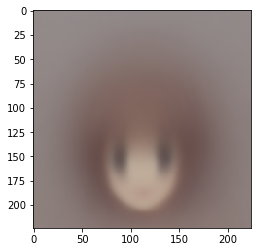

In [9]:
# 平均画像の表示
plt.imshow(mean.transpose(1, 2, 0) / 255)
plt.show()

なんか怖いですね…

## 4. モデルの定義とFine-tuningの準備

では次に、訓練を行うモデルの定義を行います。ここではIllust2Vecと呼ばれるモデルをベースとし、その最後の2層を削除してランダムに初期化された3つの全結合層を付け加えたものを新しいモデルとします。

学習時には、Illust2Vec由来の部分（3層目以下の部分）の重みは固定しておきます。つまり、新たに追加した3つの全結合層だけを訓練します。

まず、配布されているIllust2Vecモデルの訓練済みパラメータをダウンロードしてきます。

In [10]:
%%bash
if [ ! -f illust2vec_ver200.caffemodel ]; then
    curl -L -O http://illustration2vec.net/models/illust2vec_ver200.caffemodel
fi

この訓練済みパラメータはcaffemodelの形式で提供されていますが、Chainerには非常に簡単にCaffeの訓練済みモデルを読み込む機能（`CaffeFunction`）があるので、これを使ってパラメータとモデル構造をロードします。ただし、読み込みには時間がかかるため、一度読み込んだ際に得られる`Chain`オブジェクトをPython標準の`pickle`を使ってファイルに保存しておきます。こうすることで次回からの読み込みが速くなります。

実際のネットワークのコードは以下のようになります。

In [11]:
import pickle

import chainer
import chainer.links as L
import chainer.functions as F

from chainer import Chain
from chainer.links.caffe import CaffeFunction


n_classes = len(dnames)


class Illust2Vec(Chain):

    CAFFEMODEL_FN = 'illust2vec_ver200.caffemodel'
    PKL_FN = 'illust2vec_ver200.pkl'

    def __init__(self, n_classes, unchain=True):
        w = chainer.initializers.HeNormal()        
        if not os.path.exists(self.PKL_FN):  # 変換済みのChainerモデル（PKLファイル）が無い場合
            model = CaffeFunction(self.CAFFEMODEL_FN)  # CaffeModelを読み込んで保存します。（時間がかかります）
            pickle.dump(model, open(self.PKL_FN, 'wb'))  # 一度読み込んだら、次回から高速に読み込めるようPickleします。
        else:
            model = pickle.load(open(self.PKL_FN, 'rb'))
        del model.encode1  # メモリ節約のため不要なレイヤを削除します。
        del model.encode2
        del model.forwards['encode1']
        del model.forwards['encode2']
        model.layers = model.layers[:-2]
        
        super(Illust2Vec, self).__init__()
        with self.init_scope():
            self.trunk = model  # 元のIllust2Vecモデルをtrunkとしてこのモデルに含めます。
            self.fc7 = L.Linear(None, 4096, initialW=w)
            self.bn7 = L.BatchNormalization(4096)
            self.fc8 = L.Linear(4096, n_classes, initialW=w)
            
        self.unchain = True

    def __call__(self, x):
        h = self.trunk({'data': x}, ['conv6_3'])[0]  # 元のIllust2Vecモデルのconv6_3の出力を取り出します。
        if self.unchain:
            h.unchain_backward()
        h = F.dropout(F.relu(self.bn7(self.fc7(h))))  # ここ以降は新しく追加した層です。
        return self.fc8(h)
        
model = Illust2Vec(n_classes)
model = L.Classifier(model)

`__call__`の部分に`h.unchain_backward()`という記述が登場しました。`unchain_backward`は、ネットワークのある中間出力`Variable` などから呼ばれ、その時点より前のあらゆるネットワークノードの接続を断ち切ります。そのため、学習時にはこれが呼ばれた時点より前の層に誤差が伝わらなくなり、結果としてパラメータの更新も行われなくなります。

前述の

> 学習時には、Illust2Vec由来の部分（3層目以下の部分）の重みは固定しておきます

これを行うためのコードが、この`h.unchain_backward()`です。

このあたりの仕組みについて、さらに詳しくは、Define-by-RunによるChainerのautogradの仕組みを説明しているこちらの記事を参照してください。: [1-file Chainerを作る](http://qiita.com/mitmul/items/37d3932292cdd560d418)

## 5. 学習

それでは、このデータセットとモデルを用いて、学習を行ってみます。

In [12]:
from chainer import iterators
from chainer import training
from chainer import optimizers
from chainer.training import extensions
from chainer.dataset import concat_examples
from chainer.training import updaters

batchsize = 128
gpu_id = 0


def create_lr_drop(drop_ratio=0.1):
    @training.make_extension()
    def lr_drop(trainer):
        trainer.updater.get_optimizer('main').lr *= drop_ratio
    return lr_drop


# devices = {'main': 0}
# for i in range(1, 4):
#     devices['gpu{}'.format(i)] = i

train_iter = iterators.MultiprocessIterator(train, batchsize)
# train_iters = [iterators.MultiprocessIterator(i, batchsize)
#                for i in datasets.split_dataset_n_random(train, len(devices))]
valid_iter = iterators.MultiprocessIterator(
    valid, batchsize, repeat=False, shuffle=False)

optimizer = optimizers.MomentumSGD(lr=0.01)
optimizer.setup(model)
optimizer.add_hook(chainer.optimizer.WeightDecay(0.0001))

updater = training.StandardUpdater(
    train_iter, optimizer, device=gpu_id)
# updater = updaters.MultiprocessParallelUpdater(
#     train_iters, optimizer, devices=devices)

trainer = training.Trainer(updater, (120, 'epoch'), out='AnimeFace-result')
trainer.extend(extensions.LogReport())
trainer.extend(extensions.observe_lr())

trainer.extend(extensions.PrintReport(
    ['epoch', 'main/loss', 'main/accuracy',
     'validation/main/loss', 'validation/main/accuracy',
     'elapsed_time', 'lr']))

# ロスのプロットを毎エポック自動的に保存
trainer.extend(extensions.PlotReport(
        ['main/loss', 'validation/main/loss'],
        'epoch', file_name='loss.png'))

# 精度のプロットも毎エポック自動的に保存
trainer.extend(extensions.PlotReport(
        ['main/accuracy', 'validation/main/accuracy'],
        'epoch', file_name='accuracy.png'))

# モデルのtrainプロパティをFalseに設定してvalidationするextension
trainer.extend(extensions.Evaluator(valid_iter, model, device=gpu_id))

# 指定したエポックごとに学習率を10分の1にする
trainer.extend(create_lr_drop(drop_ratio=0.1), trigger=(40, 'epoch'))

trainer.run()

epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy  elapsed_time  lr        


CUDARuntimeError: cudaErrorMemoryAllocation: out of memory

In [ ]:
from IPython.display import Image
Image(filename='AnimeFace-result/loss.png')

In [ ]:
Image(filename='AnimeFace-result/accuracy.png')

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

from PIL import Image
from chainer import cuda

In [ ]:
for _ in range(15):
    x, t = valid[np.random.randint(len(valid))]
    x = cuda.to_gpu(x)
    y = F.softmax(model.predictor(x[None, ...]))

    pred = os.path.basename(d.cls_labels[int(y.data.argmax())])
    label = os.path.basename(d.cls_labels[t])
    
    print('pred:', pred, 'label:', label, pred == label)

    x = cuda.to_cpu(x)
    x += d.mean[:, None, None]

    plt.imshow(x.transpose(1, 2, 0)[:, :, ::-1] / 255.0)
    plt.show()